# Initial conditions for idealized test cases

In [1]:
import xarray as xr
import cmip_basins
import seawater

Using the temperature and salinity observations from World Ocean Atlas 2013, we're building an average T/S profile:

In [2]:
url_temp = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/archive/data/0114815/public/temperature/netcdf/decav/1.00/'
url_salt = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/archive/data/0114815/public/salinity/netcdf/decav/1.00/'

Read the yearly data

In [3]:
period = '0'  # Annual average
cperiod = str(period).zfill(2)

woa13_t = xr.open_dataset(f'{url_temp}/woa13_decav_t{cperiod}_01.nc',
                          decode_times=False, engine='pydap')
woa13_s = xr.open_dataset(f'{url_salt}/woa13_decav_s{cperiod}_01.nc',
                          decode_times=False, engine='pydap')

In [4]:
woa13_t

<xarray.Dataset>
Dimensions:             (depth: 102, lat: 180, lon: 360, nbounds: 2, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 6.0
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_an                (time, depth, lat, lon) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
    t_oa                (time, depth, lat, lon) float32 ...
    t_gp                (time, depth, lat, lon) float64 ...
Attributes:
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2013 version 2 : sea_w...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, J. I. ...
    institution:                     National Oceanographic Data Center(NODC)
    comment:                         global climatology as part of the World ...
    id:                              woa13_decav_t00_01.ncv2.0
    naming_authority:                gov.noaa.nodc
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    sea_name:                        World-Wide Distribution
    time_coverage_start:             0000-01-01
    time_coverage_duration:          P01Y
    time_coverage_resolution:        P01Y
    geospatial_lat_min:              -90.0
    geospatial_lat_max:              90.0
    geospatial_lon_min:              -180.0
    geospatial_lon_max:              180.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         5500.0
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       1.00 degrees
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       1.00 degrees
    geospatial_vertical_units:       m
    geospatial_vertical_resolution:  
    geospatial_vertical_positive:    down
    creator_name:                    Ocean Climate Laboratory
    creator_email:                   NODC.Services@noaa.gov
    creator_url:                     http://www.nodc.noaa.gov
    project:                         World Ocean Atlas
    processing_level:                processed
    keywords:                        <ISO_TOPIC_Category> Oceans</ISO_TOPIC_C...
    keywords_vocabulary:             ISO 19115
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    cdm_data_type:                   Grid
    publisher_name:                  National Oceanographic Data Center
    publisher_url:                   http://www.nodc.noaa.gov/
    publisher_email:                 NODC.Services@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA13/pr_wo...
    date_created:                    2011-09-28 
    date_modified:                   2011-09-28

Compute potential temperature

In [5]:
p = xr.apply_ufunc(seawater.eos80.pres, woa13_t.depth, woa13_t.t_an,
                   dask='parallelized',
                   output_dtypes=[woa13_t.t_an.dtype])

ptemp = xr.apply_ufunc(seawater.eos80.ptmp, woa13_s.s_an, woa13_t.t_an, p,
                       dask='parallelized',
                       output_dtypes=[woa13_t.t_an.dtype])

Populate a new dataset with potential temperature and salinity:

In [6]:
woa13 = xr.Dataset()
woa13['ptemp'] = ptemp
woa13['salt'] = woa13_s['s_an']

Compute the area of the cells:

In [7]:
def compute_area_regular_grid(ds, Rearth=6378e3):
    """ compute the cells area on a regular grid """
    import numpy as np

    rfac = 2 * np.pi * Rearth / 360

    up = {"nbounds": 1}
    down = {"nbounds": 0}
    if "time" in ds["lon_bnds"].dims:
        up.update({"time": 0})
        down.update({"time": 0})

    dx1d = rfac * (ds["lon_bnds"].isel(up) - ds["lon_bnds"].isel(down))
    dy1d = rfac * (ds["lat_bnds"].isel(up) - ds["lat_bnds"].isel(down))

    dx2d, dy2d = np.meshgrid(dx1d, dy1d)
    _, lat2d = np.meshgrid(ds["lon"].values, ds["lat"].values)

    dx = dx2d * np.cos(2 * np.pi * lat2d / 360)
    dy = dy2d
    area = dx * dy
    return area

In [8]:
woa13['area'] = xr.DataArray(compute_area_regular_grid(woa13_t),
                             dims=('lat', 'lon'))

Create a land sea mask and basin codes:

In [9]:
woa13['mask'] = xr.where(woa13['ptemp'].isel(depth=0).fillna(-9999.) == -9999., 0, 1).squeeze()

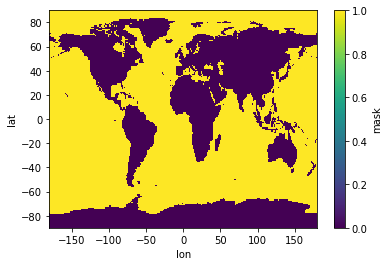

In [10]:
woa13['mask'].plot()

In [11]:
woa13['basin'] = cmip_basins.generate_basin_codes(woa13, lon='lon', lat='lat',mask='mask')

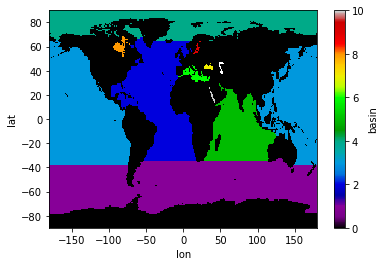

In [12]:
woa13['basin'].plot(cmap='nipy_spectral')

The resulting dataset is:

In [13]:
woa13

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 180, lon: 360, time: 1)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time     (time) float32 6.0
Data variables:
    ptemp    (time, depth, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    salt     (time, depth, lat, lon) float32 ...
    area     (lat, lon) float32 1.081e+08 1.081e+08 ... 1.081e+08 1.081e+08
    mask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
    basin    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0 4.0 4.0

## Average T/S profile for the North Pacific

Use the basin mask and latitude range to extract North Pacific:

In [14]:
NPAC = woa13.where(woa13['basin'] == 3).sel(lat=slice(0,65))

Quick check against full domain:

(-90.0, 90.0)

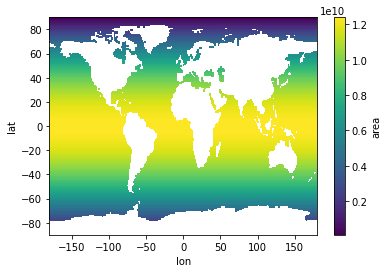

In [15]:
p = woa13['area'].where(woa13['basin'] != 0).plot()
p.axes.set_ylim([-90, 90])

(-90.0, 90.0)

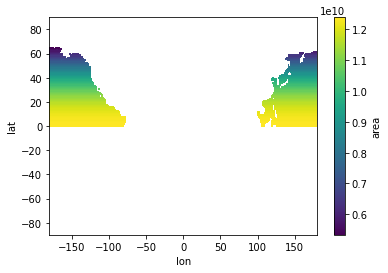

In [16]:
p = NPAC['area'].plot()
p.axes.set_ylim([-90, 90])

Compute a weighted average over lon and lat. Note that weights cannot contain missing value so we're using array from full domain:

In [17]:
Tprof = NPAC['ptemp'].weighted(woa13['area']).mean(dim=['lon', 'lat'])

In [18]:
Sprof = NPAC['salt'].weighted(woa13['area']).mean(dim=['lon', 'lat'])

In [19]:
Tprof

<xarray.DataArray (time: 1, depth: 102)>
array([[22.096375 , 22.05726  , 22.00418  , 21.91861  , 21.795637 ,
        21.644354 , 21.449001 , 21.22031  , 20.96793  , 20.700699 ,
        20.413832 , 20.121504 , 19.83173  , 19.526972 , 19.224781 ,
        18.933426 , 18.637463 , 18.344551 , 18.051188 , 17.75993  ,
        17.47667  , 16.094294 , 14.79417  , 13.642346 , 12.648653 ,
        11.859791 , 11.19583  , 10.652156 , 10.170564 ,  9.728973 ,
         9.313368 ,  8.919966 ,  8.540597 ,  8.178102 ,  7.832012 ,
         7.5005336,  7.180519 ,  6.5903673,  6.088754 ,  5.660852 ,
         5.29284  ,  5.017463 ,  4.733302 ,  4.5006113,  4.2742743,
         4.0805264,  3.9050412,  3.7405586,  3.587603 ,  3.4438725,
         3.309017 ,  3.1823468,  3.064628 ,  2.951938 ,  2.8465939,
         2.7484753,  2.654935 ,  2.5638158,  2.480999 ,  2.4013395,
         2.3271608,  2.2583857,  2.1918752,  2.1306233,  2.0717378,
         2.0169487,  1.9615624,  1.8686345,  1.7881325,  1.7194134,
         1.6615592,  1.6117843,  1.5676086,  1.5255094,  1.4869468,
         1.4513355,  1.4166424,  1.3843888,  1.354827 ,  1.3267376,
         1.3001562,  1.2761202,  1.2534492,  1.2281736,  1.2060728,
         1.1873834,  1.1683623,  1.1512415,  1.1357132,  1.1179935,
         1.1001797,  1.0885639,  1.0776068,  1.0679882,  1.0598152,
         1.0523216,  1.043868 ,  1.0360569,  1.0313731,  1.0265216,
         1.027132 ,  1.0230063]], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time     (time) float32 6.0

Compute densities:

In [20]:
def dens_wright_eos(T, S, p):
  """
  Equation of state for sea water given by Wright, 1997, J. Atmos. Ocean. Tech., 14, 735-740.
  Units: T[degC],S[PSU],p[Pa]
  Returns density [kg m-3]
  """

  a0 = 7.057924e-4; a1 = 3.480336e-7; a2 = -1.112733e-7
  b0 = 5.790749e8;  b1 = 3.516535e6;  b2 = -4.002714e4; b3 = 2.084372e2;  b4 = 5.944068e5;  b5 = -9.643486e3
  c0 = 1.704853e5;  c1 = 7.904722e2;  c2 = -7.984422;   c3 = 5.140652e-2; c4 = -2.302158e2; c5 = -3.079464

  al0 = a0 + a1*T +a2*S
  p0  = b0 + b4*S + T * (b1 + T*(b2 + b3*T) + b5*S)
  l = c0 +c4*S + T * (c1 + T*(c2 + c3*T) + c5*S)
  return (p + p0) / (l + al0*(p+p0))

In [21]:
p = seawater.eos80.pres(woa13['depth'], Tprof)
dens = dens_wright_eos(Tprof, Sprof, p)

In [22]:
dens

<xarray.DataArray (time: 1, depth: 102)>
array([[1023.50024, 1023.52075, 1023.5459 , 1023.58136, 1023.62915,
        1023.68774, 1023.7603 , 1023.84247, 1023.9305 , 1024.0228 ,
        1024.1179 , 1024.2151 , 1024.3098 , 1024.4067 , 1024.4987 ,
        1024.586  , 1024.6727 , 1024.7576 , 1024.8413 , 1024.9229 ,
        1025.0006 , 1025.3577 , 1025.655  , 1025.8834 , 1026.0637 ,
        1026.1973 , 1026.3038 , 1026.3881 , 1026.4601 , 1026.5242 ,
        1026.582  , 1026.6354 , 1026.686  , 1026.7336 , 1026.7787 ,
        1026.8215 , 1026.8634 , 1026.9414 , 1027.0099 , 1027.0714 ,
        1027.129  , 1027.1752 , 1027.2229 , 1027.264  , 1027.3018 ,
        1027.3352 , 1027.3657 , 1027.3937 , 1027.4187 , 1027.4421 ,
        1027.4639 , 1027.4839 , 1027.5021 , 1027.5194 , 1027.5354 ,
        1027.5503 , 1027.5642 , 1027.5776 , 1027.5901 , 1027.6017 ,
        1027.6124 , 1027.6226 , 1027.6324 , 1027.6417 , 1027.6503 ,
        1027.6582 , 1027.6659 , 1027.6796 , 1027.6918 , 1027.7018 ,
        1027.7101 , 1027.7174 , 1027.7238 , 1027.7299 , 1027.7355 ,
        1027.7407 , 1027.7454 , 1027.7499 , 1027.7539 , 1027.7576 ,
        1027.7611 , 1027.7645 , 1027.7677 , 1027.7716 , 1027.7747 ,
        1027.7771 , 1027.7793 , 1027.7816 , 1027.7834 , 1027.7856 ,
        1027.7878 , 1027.7893 , 1027.7903 , 1027.7915 , 1027.7924 ,
        1027.7936 , 1027.7949 , 1027.7957 , 1027.7965 , 1027.7975 ,
        1027.7975 , 1027.7981 ]], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time     (time) float32 6.0

build the dataset in layer mode:

In [23]:
NPAC_profile = xr.Dataset()
NPAC_profile['Layer'] = xr.DataArray(data=dens.squeeze().values[:97], dims=('Layer'),
                                     attrs = dict(long_name = "Layer Target Potential Density",
                                                  units = "kg m-3",
                                                  cartesian_axis = "Z",
                                                  positive = "up"))
NPAC_profile['ptemp'] = xr.DataArray(data=Tprof.squeeze().values[:97], dims=('Layer'),
                                    attrs= dict(long_name = "Potential Temperature",
                                                  units = "deg C",
                                                  cartesian_axis = "Z",
                                                  positive = "up"))
NPAC_profile['salt'] = xr.DataArray(data=Sprof.squeeze().values[:97], dims=('Layer'),
                                    attrs = dict(long_name = "Salinity",
                                                  units = "PSU",
                                                  cartesian_axis = "Z",
                                                  positive = "up"))
NPAC_profile['depth'] = xr.DataArray(data=Tprof['depth'].squeeze().values[:97], dims=('Layer'),
                                     attrs = dict(long_name = "Layer average Depth",
                                                  units = "m",
                                                  cartesian_axis = "Z",
                                                  positive = "up"))

In [24]:
NPAC_profile

<xarray.Dataset>
Dimensions:  (Layer: 97)
Coordinates:
  * Layer    (Layer) float64 1.024e+03 1.024e+03 ... 1.028e+03 1.028e+03
Data variables:
    ptemp    (Layer) float32 22.1 22.06 22.0 21.92 ... 1.068 1.06 1.052 1.044
    salt     (Layer) float32 34.09 34.1 34.11 34.13 ... 34.69 34.69 34.69 34.69
    depth    (Layer) float32 0.0 5.0 10.0 15.0 ... 4.7e+03 4.8e+03 4.9e+03 5e+03

In [25]:
NPAC_profile.to_netcdf('coordinates_NPAC_profile.nc', format='NETCDF3_CLASSIC')